# Data Analysis for  WeRateDogs Twitter archive

## Table of Contents

[1 Introduction](#intro)

[2 Gathering Data](#2)

[3 Data Wrangling](#3)

[4 Explorary Data Analysis](#4)

[5 Conclusion and Limitations](#5)

<a id='#intro'></a>
## 1 Introduction
> Twitter is one of the most popular social media where people post and interact with messages known as "tweets". It can be really interesting to dive into the user accounts with large follower base. For this project, we analyze a specific user account "WeRateDogs". This a micro-community for dog lover to share funny and adorable photos of dogs. 

> This project consist of three sections, data gathering, data wrangling and explorary data analysis. The first two sections focus on generating clean and tidy dataset, then the dataset is export to .csv file and .db file for later analysis. The explorary data analysis uses the clean dataset derived from the previous sections and conduct analysis to provide insights on the trends of popular dogs based on retweet count, favorate count and image prediction results.

In [1]:
import numpy as np
import pandas as pd
import requests
import io
import os
import tweepy
from tweepy import OAuthHandler
import json
import timeit
import re
import datetime
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
import seaborn as sns
import calendar
from sklearn.linear_model import LinearRegression

<a id='2'></a>
## 2 Gathering Data
There are three data resources:
* Manually download: `twitter_archive_enhanced.csv`
* Derive from Udacity's servers: `image_predictions.tsv`
* Derive by Tweepy: `tweet_json.txt`

>`twitter_archive_enhanced.csv`: This file is downloaded manually and stores under the same path of this notebook for accessibility.

>`image_predictions.tsv`: This file is obtained using requests library in [section 2.1](need a html link here)

>`tweet_json.txt`: This file is obtained using requests library in [section 2.2](need a html link here)

### 2.1 Read `twitter_archive_enhanced.csv` from Udacity's servers 

In [2]:
twitter_archive = pd.read_csv('twitter-archive-enhanced.csv')

### 2.1 Extract `image_predictions.tsv` from Udacity's servers 

In [3]:
url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
urlData = requests.get(url).content
img_pred = pd.read_csv(io.StringIO(urlData.decode('utf-8')),sep='\t')

In [4]:
img_pred.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


### 2.2 Extract data using twitter API

In [5]:
# read key value pairs from a json file.
with open('config.json') as f:
    config = json.load(f)

In [6]:
consumer_key = config['consumer_key']
consumer_secret = config['consumer_secret']
access_token = config['access_token']
access_secret = config['access_secret']

In [7]:
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

api = tweepy.API(auth, wait_on_rate_limit=True)

In [8]:
# start to retrieve data from twitter
# Since this takes more than 20 mins, check if the file exist or not.
# If the file exist, just skip this step.
if not os.path.exists("tweet_json.txt"):
    start = timeit.timeit() # set up a timer
    fails_dict={} # collect deleted ids
    count = 0 # get the processing status
    with open('tweet_json.txt', 'w') as outfile:
        for twt_id in img_pred['tweet_id']:
            try:
                tweet = api.get_status(twt_id,tweet_mode='extended',wait_on_rate_limit=True,wait_on_rate_limit_notify=True)
                print('{} record success'.format(count),end="\r")
                json.dump(tweet._json, outfile)
                outfile.write('\n')
            except tweepy.TweepError as e:
                print('Fail',end="\r")
                fails_dict[twt_id] = e
                pass
            count += 1
else:
    print("File already exist!")

File already exist!


In [9]:
df_api = pd.DataFrame(columns=['id','display_text_range','retweet_count','favorite_count'])
with open('tweet_json.txt') as json_file:
    for line in json_file:
        data_str = json.loads(line)
        data_parse = pd.DataFrame.from_dict(data_str,orient="index")
        data_interested = data_parse[0][['id','display_text_range','retweet_count','favorite_count']]
        df_api = df_api.append(data_interested,ignore_index=True)

In [10]:
df_api.head()

,id,display_text_range,retweet_count,favorite_count
0,666020888022790149,"[0, 131]",466,2434
1,666029285002620928,"[0, 139]",42,121
2,666033412701032449,"[0, 130]",41,113
3,666044226329800704,"[0, 137]",133,274
4,666049248165822465,"[0, 120]",41,99


<a id='3'></a>
## 3 Data Wrangling
In the previous section, three tables are generated from different sources. In this sections, each table is carefully assessed and cleaned. The three dataframes are listed below:

* `twitter_archive`: retrieved from a .csv file
* `img_pred`: retrieved from Udacity server
* `df_api`: retrieved from twitter

### 3.1 Data Assesssing

#### 3.1.1 Data Assessing: `twitter_archive` table
**Quality issues**
* more than 50% of NAN values in columns related `in_reply_to` and `retweeted_status`
* redundant information in `source` column.
* Nones in columns `['doggo','floofer','pupper','puppo']`
* incorrect ratings
* incorrect ['doggo','floofer','pupper','puppo']
* Erroneous datatypes(timestamp,source,doggo,floofer,pupper,puppo)
* incorrect name for the dogs with name 'a' or 'None', some of them have a name and so of them do not have a name.
* contains retweeted tweets (without image)

**Tidniess issues**
* Text column contains multiple variables: text, rate and url


In [11]:
twitter_archive

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2351,666049248165822465,NaN,NaN,2015-11-16 00:24:50 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a 1949 1st generation vulpix. Enj...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666049248...,5,10,None,None,None,None,None
2352,666044226329800704,NaN,NaN,2015-11-16 00:04:52 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a purebred Piers Morgan. Loves to Netf...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666044226...,6,10,a,None,None,None,None
2353,666033412701032449,NaN,NaN,2015-11-15 23:21:54 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here is a very happy pup. Big fan of well-main...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666033412...,9,10,a,None,None,None,None
2354,666029285002620928,NaN,NaN,2015-11-15 23:05:30 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a western brown Mitsubishi terrier. Up...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666029285...,7,10,a,None,None,None,None


In [12]:
twitter_archive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        2356 non-null   object 
 13  doggo                       2356 

In [13]:
twitter_archive.source.value_counts()

<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>     2221
<a href="http://vine.co" rel="nofollow">Vine - Make a Scene</a>                          91
<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>                       33
<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>      11
Name: source, dtype: int64

In [14]:
for i in range(0,100):
    print('record index: '+ str(i) + '\n'+ twitter_archive.text[i] + '\nstage: ' + twitter_archive.puppo[i])

record index: 0
This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU
stage: None
record index: 1
This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV
stage: None
record index: 2
This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZnhtVJB
stage: None
record index: 3
This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us https://t.co/tD36da7qLQ
stage: None
record index: 4
This is Franklin. He would like you to stop calling him "cute." He is a very fierce shark and should be respected as such. 12/10 #BarkWeek https://t.co/AtUZn91f7f
stage: None
record index: 5
Here we have a majestic great white breaching off South Africa's coast. Absolutely h*ckin breathtaking. 13/10 (IG: tucker_marlo) #BarkWeek https://t.co/kQ04fD

In [15]:
twitter_archive['doggo'].value_counts()

None     2259
doggo      97
Name: doggo, dtype: int64

In [16]:
twitter_archive['name'].value_counts()

None        745
a            55
Charlie      12
Lucy         11
Oliver       11
           ... 
Strider       1
Florence      1
Duchess       1
Gòrdón        1
Jeffri        1
Name: name, Length: 957, dtype: int64

In [17]:
pd.set_option('display.max_colwidth', -1)
twitter_archive[twitter_archive.name == 'a'].text

D:\anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  """Entry point for launching an IPython kernel.


56      Here is a pupper approaching maximum borkdrive. Zooming at never before seen speeds. 14/10 paw-inspiring af \n(IG: puffie_the_chow) https://t.co/ghXBIIeQZF
649     Here is a perfect example of someone who has their priorities in order. 13/10 for both owner and Forrest https://t.co/LRyMrU7Wfq                           
801     Guys this is getting so out of hand. We only rate dogs. This is a Galapagos Speed Panda. Pls only send dogs... 10/10 https://t.co/8lpAGaZRFn               
1002    This is a mighty rare blue-tailed hammer sherk. Human almost lost a limb trying to take these. Be careful guys. 8/10 https://t.co/TGenMeXreW               
1004    Viewer discretion is advised. This is a terrible attack in progress. Not even in water (tragic af). 4/10 bad sherk https://t.co/L3U0j14N5R                 
1017    This is a carrot. We only rate dogs. Please only send in dogs. You all really should know this by now ...11/10 https://t.co/9e48aPrBm2                     
1049    This is 

####  3.1.2 Data Assessing: `img_pred` table
This table is pretty clean without any issues for now.

In [18]:
img_pred

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True
...,...,...,...,...,...,...,...,...,...,...,...,...
2070,891327558926688256,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,2,basset,0.555712,True,English_springer,0.225770,True,German_short-haired_pointer,0.175219,True
2071,891689557279858688,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,1,paper_towel,0.170278,False,Labrador_retriever,0.168086,True,spatula,0.040836,False
2072,891815181378084864,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,1,Chihuahua,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True
2073,892177421306343426,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1,Chihuahua,0.323581,True,Pekinese,0.090647,True,papillon,0.068957,True


In [19]:
img_pred.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  2075 non-null   int64  
 1   jpg_url   2075 non-null   object 
 2   img_num   2075 non-null   int64  
 3   p1        2075 non-null   object 
 4   p1_conf   2075 non-null   float64
 5   p1_dog    2075 non-null   bool   
 6   p2        2075 non-null   object 
 7   p2_conf   2075 non-null   float64
 8   p2_dog    2075 non-null   bool   
 9   p3        2075 non-null   object 
 10  p3_conf   2075 non-null   float64
 11  p3_dog    2075 non-null   bool   
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [20]:
img_pred.describe()

,tweet_id,img_num,p1_conf,p2_conf,p3_conf
count,2.075000e+03,2075.000000,2075.000000,2.075000e+03,2.075000e+03
mean,7.384514e+17,1.203855,0.594548,1.345886e-01,6.032417e-02
std,6.785203e+16,0.561875,0.271174,1.006657e-01,5.090593e-02
min,6.660209e+17,1.000000,0.044333,1.011300e-08,1.740170e-10
25%,6.764835e+17,1.000000,0.364412,5.388625e-02,1.622240e-02
50%,7.119988e+17,1.000000,0.588230,1.181810e-01,4.944380e-02
75%,7.932034e+17,1.000000,0.843855,1.955655e-01,9.180755e-02
max,8.924206e+17,4.000000,1.000000,4.880140e-01,2.734190e-01


####  3.1.3 Data Assessing: `df_api` table
**Quality issues**
* '[]' and starting point of the range for `display_text_range`
* Erroneous datatypes `display_text_range`, `retweet_count` and `favorite_count`


In [21]:
df_api

,id,display_text_range,retweet_count,favorite_count
0,666020888022790149,"[0, 131]",466,2434
1,666029285002620928,"[0, 139]",42,121
2,666033412701032449,"[0, 130]",41,113
3,666044226329800704,"[0, 137]",133,274
4,666049248165822465,"[0, 120]",41,99
...,...,...,...,...
2054,891327558926688256,"[0, 138]",8555,38021
2055,891689557279858688,"[0, 79]",7926,39825
2056,891815181378084864,"[0, 121]",3808,23699
2057,892177421306343426,"[0, 138]",5752,31449


In [22]:
df_api.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2059 entries, 0 to 2058
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   id                  2059 non-null   object
 1   display_text_range  2059 non-null   object
 2   retweet_count       2059 non-null   object
 3   favorite_count      2059 non-null   object
dtypes: object(4)
memory usage: 64.5+ KB


### 3.2 Data Cleaning

In [23]:
twitter_archive_clean = twitter_archive.copy()
img_pred_clean = img_pred.copy()
df_api_clean = df_api.copy()

**Issue:** table `twitter_archive_clean` More than 50% of NAN values in columns related `in_reply_to` and `retweeted_status`.

**Define**: since these infomation is trivial for the later analysis, these columns are dropped.

In [24]:
labels =  ['in_reply_to_status_id','in_reply_to_user_id','retweeted_status_id','retweeted_status_user_id','retweeted_status_timestamp']
twitter_archive_clean = twitter_archive_clean.drop(columns = labels, axis = 1 )

In [25]:
# test
twitter_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   tweet_id            2356 non-null   int64 
 1   timestamp           2356 non-null   object
 2   source              2356 non-null   object
 3   text                2356 non-null   object
 4   expanded_urls       2297 non-null   object
 5   rating_numerator    2356 non-null   int64 
 6   rating_denominator  2356 non-null   int64 
 7   name                2356 non-null   object
 8   doggo               2356 non-null   object
 9   floofer             2356 non-null   object
 10  pupper              2356 non-null   object
 11  puppo               2356 non-null   object
dtypes: int64(3), object(9)
memory usage: 221.0+ KB


**Issue:** table `twitter_archive_clean` redundant information in `source` column

**Define:** remove the html tags using regular expression

In [26]:
twitter_archive_clean = twitter_archive_clean.replace({'source': r'<[^>]*>'}, {'source': ''}, regex=True)

In [27]:
# test
twitter_archive_clean.source.value_counts()

Twitter for iPhone     2221
Vine - Make a Scene    91  
Twitter Web Client     33  
TweetDeck              11  
Name: source, dtype: int64

**Issue:** table `twitter_archive_clean`, `text` column contains multiple variables (text, rate, url)

**Define:** add a new column `Full_text` to store text, extract the text using regular expression

In [28]:
twitter_archive_clean['url'] = twitter_archive_clean.text.str.extract('(http.*)')
twitter_archive_clean['rate'] = twitter_archive_clean.text.str.extract('(\d+\/\d+)')

In [29]:
twitter_archive_clean['Full_text'] = twitter_archive_clean.text.str.replace('(http.*)','').str.replace('(\d+\/\d+)','')

In [30]:
# test I
twitter_archive_clean[['text','url','rate','Full_text']].sample(10)

,text,url,rate,Full_text
2291,This is Churlie. AKA Fetty Woof. Lost eye saving a school bus full of toddlers from a tsunami. Great guy. 10/10 https://t.co/li2XYBVuAY,https://t.co/li2XYBVuAY,10/10,This is Churlie. AKA Fetty Woof. Lost eye saving a school bus full of toddlers from a tsunami. Great guy.
1635,Someone help the girl is being mugged. Several are distracting her while two steal her shoes. Clever puppers 121/110 https://t.co/1zfnTJLt55,https://t.co/1zfnTJLt55,121/110,Someone help the girl is being mugged. Several are distracting her while two steal her shoes. Clever puppers
2246,This is Tedrick. He lives on the edge. Needs someone to hit the gas tho. Other than that he's a baller. 10&amp;2/10 https://t.co/LvP1TTYSCN,https://t.co/LvP1TTYSCN,2/10,This is Tedrick. He lives on the edge. Needs someone to hit the gas tho. Other than that he's a baller. 10&amp;
1338,This is Reese. He's a Chilean Sohcahtoa. Loves to swing. Never sure what to do with his feet. 12/10 huggable af https://t.co/VA6jnNUyuW,https://t.co/VA6jnNUyuW,12/10,This is Reese. He's a Chilean Sohcahtoa. Loves to swing. Never sure what to do with his feet. huggable af
312,Meet Lola. Her hobbies include being precious af and using her foot as a toothbrush. 12/10 Lola requests your help\n\nhttps://t.co/FYFyHh7rir https://t.co/IiB7ggduoU,https://t.co/FYFyHh7rir https://t.co/IiB7ggduoU,12/10,Meet Lola. Her hobbies include being precious af and using her foot as a toothbrush. Lola requests your help\n\n
611,@JODYHiGHROLLER it may be an 11/10 but what do I know 😉,NaN,11/10,@JODYHiGHROLLER it may be an but what do I know 😉
520,"This is Gus. He likes to be close to you, which is good because you want to be close to Gus. 12/10 would boop then pet https://t.co/DrsrQkEfnb",https://t.co/DrsrQkEfnb,12/10,"This is Gus. He likes to be close to you, which is good because you want to be close to Gus. would boop then pet"
1603,This is the newly formed pupper a capella group. They're just starting out but I see tons of potential. 8/10 for all https://t.co/wbAcvFoNtn,https://t.co/wbAcvFoNtn,8/10,This is the newly formed pupper a capella group. They're just starting out but I see tons of potential. for all
1848,This is Bernie. He just touched a boob for the first time. 10/10 https://t.co/whQKMygnK6,https://t.co/whQKMygnK6,10/10,This is Bernie. He just touched a boob for the first time.
2144,This is Andru. He made his very own lacrosse stick. Much dedication. Big dreams. Tongue slip. 11/10 go get em Andru https://t.co/1VJoY3OJ1F,https://t.co/1VJoY3OJ1F,11/10,This is Andru. He made his very own lacrosse stick. Much dedication. Big dreams. Tongue slip. go get em Andru


In [31]:
# test II
twitter_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   tweet_id            2356 non-null   int64 
 1   timestamp           2356 non-null   object
 2   source              2356 non-null   object
 3   text                2356 non-null   object
 4   expanded_urls       2297 non-null   object
 5   rating_numerator    2356 non-null   int64 
 6   rating_denominator  2356 non-null   int64 
 7   name                2356 non-null   object
 8   doggo               2356 non-null   object
 9   floofer             2356 non-null   object
 10  pupper              2356 non-null   object
 11  puppo               2356 non-null   object
 12  url                 2286 non-null   object
 13  rate                2356 non-null   object
 14  Full_text           2356 non-null   object
dtypes: int64(3), object(12)
memory usage: 276.2+ KB


**Issue:** table `twitter_archive_clean` has incorrect ratings in `rating_numrating_numerator` and `rating_denominator`
**Define:** replace this two columns by splitting the values in `rates`.

In [32]:
twitter_archive_clean['rating_numerator'], twitter_archive_clean['rating_denominator'] = twitter_archive_clean.rate.str.split(pat = '/').str

D:\anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  """Entry point for launching an IPython kernel.


In [33]:
twitter_archive_clean['rating_numerator'] = twitter_archive_clean['rating_numerator'].astype(int)
twitter_archive_clean['rating_denominator'] = twitter_archive_clean['rating_denominator'].astype(int)

In [34]:
# test
twitter_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   tweet_id            2356 non-null   int64 
 1   timestamp           2356 non-null   object
 2   source              2356 non-null   object
 3   text                2356 non-null   object
 4   expanded_urls       2297 non-null   object
 5   rating_numerator    2356 non-null   int32 
 6   rating_denominator  2356 non-null   int32 
 7   name                2356 non-null   object
 8   doggo               2356 non-null   object
 9   floofer             2356 non-null   object
 10  pupper              2356 non-null   object
 11  puppo               2356 non-null   object
 12  url                 2286 non-null   object
 13  rate                2356 non-null   object
 14  Full_text           2356 non-null   object
dtypes: int32(2), int64(1), object(12)
memory usage: 257.8+ KB


In [35]:
# test
twitter_archive_clean[['rating_numerator','rating_denominator']].describe()

,rating_numerator,rating_denominator
count,2356.000000,2356.000000
mean,13.126486,10.455433
std,45.876648,6.745237
min,0.000000,0.000000
25%,10.000000,10.000000
50%,11.000000,10.000000
75%,12.000000,10.000000
max,1776.000000,170.000000


**Issue:** table `twitter_archive_clean`, `timestamp` column has the incorrect data type.

**Define:** convert `timestamp` to datetime datatype

In [36]:
twitter_archive_clean.timestamp = pd.to_datetime(twitter_archive_clean.timestamp)

In [37]:
# test
twitter_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   tweet_id            2356 non-null   int64              
 1   timestamp           2356 non-null   datetime64[ns, UTC]
 2   source              2356 non-null   object             
 3   text                2356 non-null   object             
 4   expanded_urls       2297 non-null   object             
 5   rating_numerator    2356 non-null   int32              
 6   rating_denominator  2356 non-null   int32              
 7   name                2356 non-null   object             
 8   doggo               2356 non-null   object             
 9   floofer             2356 non-null   object             
 10  pupper              2356 non-null   object             
 11  puppo               2356 non-null   object             
 12  url                 2286 non-null 

**Issue:** table `twitter_archive_clean`, `['doggo','floofer','pupper','puppo']` columns have the incorrect values.

**Define:** use contain to find the entries containing the key words in `Full_text` column. The key words are defined by regular expression. Then replace these columns with new values ('True's and 'False's)

In [38]:
pats = {'doggo':'[Dd][Oo][Gg][Gg][Oo]','floofer':'[Ff][Ll][Oo][Oo][Ff][Ee][Rr]',
       'pupper':'[Pp][Uu][Pp][Pp][Ee][Rr]', 'puppo':'[Pp][Uu][Pp][Pp][Oo]'}
for pat in pats.keys():
    pattern = pats[pat]
    twitter_archive_clean[pat] = twitter_archive_clean.Full_text.str.contains(pattern,regex = True)

In [39]:
twitter_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   tweet_id            2356 non-null   int64              
 1   timestamp           2356 non-null   datetime64[ns, UTC]
 2   source              2356 non-null   object             
 3   text                2356 non-null   object             
 4   expanded_urls       2297 non-null   object             
 5   rating_numerator    2356 non-null   int32              
 6   rating_denominator  2356 non-null   int32              
 7   name                2356 non-null   object             
 8   doggo               2356 non-null   bool               
 9   floofer             2356 non-null   bool               
 10  pupper              2356 non-null   bool               
 11  puppo               2356 non-null   bool               
 12  url                 2286 non-null 

In [40]:
# test
twitter_archive_clean[twitter_archive_clean.doggo == True].Full_text.sample(10)

240    This is Barney. He's an elder doggo. Hitches a ride when he gets tired. Waves goodbye before he leaves.  please come back soon 
835    Meet Gerald. He's a fairly exotic doggo. Floofy af. Inadequate knees tho. Self conscious about large forehead.                 
425    RT @dog_rates: This is Sampson. He just graduated. Ready to be a doggo now. Time for the real world.  have fun with taxes      
565    Like doggo, like pupper version 2. Both                                                                                        
778    RT @dog_rates: Like father (doggo), like son (pupper). Both                                                                    
877    This is Wishes. He has the day off. Daily struggles of being a doggo have finally caught up with him.                          
624    Elder doggo does a splash. Both  incredible stuff                                                                              
944    Nothing better than a doggo and a sunset.  majes

In [41]:
twitter_archive_clean[twitter_archive_clean.floofer == True].Full_text.sample(10)

582     This is Doc. He takes time out of every day to worship our plant overlords.  quite the floofer                                          
200     At first I thought this was a shy doggo, but it's actually a Rare Canadian Floofer Owl. Amateurs would confuse the two.  only send dogs 
984     This is Blu. He's a wild bush Floofer. I wish anything made me as happy as bushes make Blu.  would frolic with                          
46      Meet Grizzwald. He may be the floofiest floofer I ever did see. Lost eyes saving a schoolbus from a volcano erpuption.  heroic as h*ck  
1534    Here we are witnessing a rare High Stepping Alaskan Floofer.  dangerously petable (vid by @TheMrsNux)                                   
1614    Say hello to Petrick. He's an Altostratus Floofer. Just had a run in with a trash bag. Groovy checkered floor.                          
1110    This is Moose. He's a Polynesian Floofer. Dapper af.  would pet diligently                                                

In [42]:
twitter_archive_clean[twitter_archive_clean.pupper == True].Full_text.sample(10)

465     RT @dog_rates: Here's a pupper with squeaky hiccups. Please enjoy.                                                   
92      This is Jed. He may be the fanciest pupper in the game right now. Knows it too.  would sign modeling contract        
132     RT @dog_rates: This is Jamesy. He gives a kiss to every other pupper he sees on his walk.  such passion, much tender 
1970    Meet Eve. She's a raging alcoholic  (would b  but pupper alcoholism is a tragic issue that I can't condone)          
1658    This is Larry. He thought the New Year's parties were tonight.  poor pupper. Maybe next year                         
1489    This is Wally. He's being abducted by aliens.  poor pupper                                                           
1428    This pupper doubles as a hallway rug. Very rare. Versatile af.                                                       
1826    Hope your Monday isn't too awful. Here's two baseball puppers.  for each                                      

In [43]:
twitter_archive_clean[twitter_archive_clean.puppo == True].Full_text.sample(10)

546     RT @dog_rates: This is Reginald. He's one magical puppo. Aerodynamic af.  would catch                                               
168     Sorry for the lack of posts today. I came home from school and had to spend quality time with my puppo. Her name is Zoey and she's  
397     RT @dog_rates: Say hello to Pablo. He's one gorgeous puppo. A true . Click the link to see why Pablo requests your assistance\n\n   
129     This is Shikha. She just watched you drop a skittle on the ground and still eat it. Could not be less impressed.  superior puppo    
191     Here's a puppo participating in the #ScienceMarch. Cleverly disguising her own doggo agenda.  would keep the planet habitable for   
439     This is Oliver. He has dreams of being a service puppo so he can help his owner.  selfless af\n\nmake it happen:\n                  
961     This is Cooper. He's just so damn happy.  what's your secret puppo?                                                                 
1035    This 

**Issue:** table `twitter_archive_clean`, `name` column contains several incorrect names (assigned 'a')

**Define:** use str.contains to find the correct names and replace the incorrected names("a" and "None").

In [44]:
# GET ALL CORRECT NAMES
# select 
nan_name = twitter_archive_clean.query('name == "a" or name == "None"')
# pattern 1: named xxx, pattern 2: name is xxx
corrected_names = pd.DataFrame()
patterns = ['(named\s(\w+))','(name\sis\s(\w+))']
for pat in patterns:
    names = nan_name.Full_text.str.extract(pat)[1].dropna().to_frame()
    corrected_names = corrected_names.append(names)

In [45]:
# reset the indices and rename the column in a more decriptive way.
corrected_names = corrected_names.reset_index()
corrected_names = corrected_names.rename(columns = {'index':'ind',1:'cor_name'})

In [46]:
twitter_archive_clean.name[603]

'None'

In [47]:
# replace the incorrect names with the correct name.
length = len(corrected_names)
for i in range(length):
    twitter_archive_clean.name[corrected_names.ind[i]] = corrected_names.cor_name[i]

D:\anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [48]:
# text
a = twitter_archive_clean.query('name == "a" or name == "None" and Full_text.str.contains("name|call")',engine='python')

a[['name','Full_text']].sample(10)

,name,Full_text
1785,a,This is a dog swinging. I really enjoyed it so I hope you all do as well.
2348,a,Here is a Siberian heavily armored polar bear mix. Strong owner. I would do unspeakable things to pet this dog
2350,a,This is a truly beautiful English Wilson Staff retriever. Has a nice phone. Privileged. would trade lives with
2327,a,This is a southern Vesuvius bumblegruff. Can drive a truck (wow). Made friends with 5 other nifty dogs (neat).
1340,a,Here is a heartbreaking scene of an incredible pupper being laid to rest. RIP pupper
1994,a,This is a baby Rand Paul. Curls for days. would cuddle the hell out of
2086,None,I would do radical things in the name of Dog God. I'd believe every word in that book.
1737,a,Guys this really needs to stop. We've been over this way too many times. This is a giraffe. We only rate dogs..
1878,a,This is a fluffy albino Bacardi Columbia mix. Excellent at the tweets. would hug gently
1004,a,Viewer discretion is advised. This is a terrible attack in progress. Not even in water (tragic af). bad sherk


**Issue:** table `twitter_archive_clean`, contains retweeted tweets (without image)

**Define:** merge table `img_pred_clean` to `twitter_archive_clean`.


In [49]:
twitter_archive_clean = twitter_archive_clean.merge(img_pred_clean,left_on='tweet_id',right_on='tweet_id')

In [50]:
# test
twitter_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2075 entries, 0 to 2074
Data columns (total 26 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   tweet_id            2075 non-null   int64              
 1   timestamp           2075 non-null   datetime64[ns, UTC]
 2   source              2075 non-null   object             
 3   text                2075 non-null   object             
 4   expanded_urls       2075 non-null   object             
 5   rating_numerator    2075 non-null   int32              
 6   rating_denominator  2075 non-null   int32              
 7   name                2075 non-null   object             
 8   doggo               2075 non-null   bool               
 9   floofer             2075 non-null   bool               
 10  pupper              2075 non-null   bool               
 11  puppo               2075 non-null   bool               
 12  url                 2075 non-null 

**Issue:** table `df_api`, column `display_text_range` have '[]' and starting point of the range.

**Define:** extract the length of the text from list objects.

In [51]:
df_api_clean['text_len'] = pd.DataFrame({'text_len':df_api_clean.display_text_range[i][1]} for i in range(len(df_api_clean)))

In [52]:
df_api_clean.head()

,id,display_text_range,retweet_count,favorite_count,text_len
0,666020888022790149,"[0, 131]",466,2434,131
1,666029285002620928,"[0, 139]",42,121,139
2,666033412701032449,"[0, 130]",41,113,130
3,666044226329800704,"[0, 137]",133,274,137
4,666049248165822465,"[0, 120]",41,99,120


In [53]:
df_api_clean = df_api_clean.rename(columns={'id':'tweet_id'})

In [54]:
df_api_clean = df_api_clean.drop('display_text_range',axis = 1)

In [55]:
df_api_clean.head()

,tweet_id,retweet_count,favorite_count,text_len
0,666020888022790149,466,2434,131
1,666029285002620928,42,121,139
2,666033412701032449,41,113,130
3,666044226329800704,133,274,137
4,666049248165822465,41,99,120


**Issue:** Erroneous datatypes `tweet_id`, `retweet_count` and `favorite_count`.

**Define:** convert strings to int64 using `astype()`


In [56]:
df_api_clean.retweet_count = df_api_clean.retweet_count.astype('int64')
df_api_clean.favorite_count = df_api_clean.favorite_count.astype('int64')
df_api_clean.tweet_id = df_api_clean.tweet_id.astype('int64')

In [57]:
# test
df_api_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2059 entries, 0 to 2058
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   tweet_id        2059 non-null   int64
 1   retweet_count   2059 non-null   int64
 2   favorite_count  2059 non-null   int64
 3   text_len        2059 non-null   int64
dtypes: int64(4)
memory usage: 64.5 KB


merge `df_api_clean` table to `twitter_archive_clean` table 

In [58]:
# merge df_api_clean and twitter_archive_clean to twitter_clean
twitter_clean = twitter_archive_clean.copy()

In [59]:
twitter_clean = twitter_clean.merge(df_api_clean,left_on='tweet_id',
    right_on='tweet_id')

In [60]:
twitter_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2059 entries, 0 to 2058
Data columns (total 29 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   tweet_id            2059 non-null   int64              
 1   timestamp           2059 non-null   datetime64[ns, UTC]
 2   source              2059 non-null   object             
 3   text                2059 non-null   object             
 4   expanded_urls       2059 non-null   object             
 5   rating_numerator    2059 non-null   int32              
 6   rating_denominator  2059 non-null   int32              
 7   name                2059 non-null   object             
 8   doggo               2059 non-null   bool               
 9   floofer             2059 non-null   bool               
 10  pupper              2059 non-null   bool               
 11  puppo               2059 non-null   bool               
 12  url                 2059 non-null 

**Issue:** table `twitter_archive_clean`, contains retweeted tweets (RT, and identical retweet counts)

**Define:** remove rows that `Full_text` column with pattern: RT @xxxx

In [61]:
RT = (twitter_clean.Full_text.str.contains('RT\s@\w+') == True)
twitter_clean[RT]['Full_text']

32      RT @dog_rates: This is Lilly. She just parallel barked. Kindly requests a reward now.  would pet so well 
67      RT @rachel2195: @dog_rates the boyfriend and his soaking wet pupper h*cking love his new hat             
107     RT @rachaeleasler: these @dog_rates hats are  bean approved                                              
130     RT @tallylott: h*ckin adorable promposal.  @dog_rates                                                    
167     RT @eddie_coe98: Thanks @dog_rates completed my laptop.  would buy again                                 
                                          ...                                                                    
745     RT @dog_rates: This is Rubio. He has too much skin.                                                      
762     RT @dog_rates: Everyone needs to watch this.                                                             
1022    RT @twitter: @dog_rates Awesome Tweet! . Would Retweet. #LoveTwitter            

In [62]:
RT_ind = twitter_clean[RT].index

In [63]:
twitter_clean = twitter_clean.drop(RT_ind,axis=0).reset_index()

In [64]:
# test
sum(twitter_clean.Full_text.str.contains('RT\s@\w+') == True)

0

### 3.3 Export clean data 

In [65]:
# Drop columns that we are not interested in.
drop_columns = ['text','expanded_urls','url','rate','jpg_url']
twitter_clean.drop(drop_columns,axis=1,inplace=True)

In [66]:
# test
twitter_clean.head()

,index,tweet_id,timestamp,source,rating_numerator,rating_denominator,name,doggo,floofer,pupper,...,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,retweet_count,favorite_count,text_len
0,0,892420643555336193,2017-08-01 16:23:56+00:00,Twitter for iPhone,13,10,Phineas,False,False,False,...,False,bagel,0.085851,False,banana,0.076110,False,7759,36489,85
1,1,892177421306343426,2017-08-01 00:17:27+00:00,Twitter for iPhone,13,10,Tilly,False,False,False,...,True,Pekinese,0.090647,True,papillon,0.068957,True,5752,31449,138
2,2,891815181378084864,2017-07-31 00:18:03+00:00,Twitter for iPhone,12,10,Archie,False,False,False,...,True,malamute,0.078253,True,kelpie,0.031379,True,3808,23699,121
3,3,891689557279858688,2017-07-30 15:58:51+00:00,Twitter for iPhone,13,10,Darla,False,False,False,...,False,Labrador_retriever,0.168086,True,spatula,0.040836,False,7926,39825,79
4,4,891327558926688256,2017-07-29 16:00:24+00:00,Twitter for iPhone,12,10,Franklin,False,False,False,...,True,English_springer,0.225770,True,German_short-haired_pointer,0.175219,True,8555,38021,138


In [67]:
# create a csv file for clean data.
twitter_clean.to_csv('twitter_archive_master.csv', sep=',', encoding='utf-8',index=False);

In [68]:
# create a sqlite database for clean data.
engine = create_engine('sqlite:///twitter_archive_master.db', echo=False)
twitter_clean.to_sql('twitter_archive_master', con=engine,if_exists='replace')

<a id='4'></a>
## 4 Exploratory Data Analysis
In this section, we use the clean data to answer the following questions:
* Which tweet has the most retweets and/or the most likes?
* Which breed of dogs has the most tweets based on the predictions, what about the trend of breeds?
* What is the trend of average content length, retweet counts and favorite counts?
* Any relationship beween retweet count and favorite count?

In [69]:
df = pd.read_csv('twitter_archive_master.csv')

In [70]:
df.head()

,index,tweet_id,timestamp,source,rating_numerator,rating_denominator,name,doggo,floofer,pupper,...,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,retweet_count,favorite_count,text_len
0,0,892420643555336193,2017-08-01 16:23:56+00:00,Twitter for iPhone,13,10,Phineas,False,False,False,...,False,bagel,0.085851,False,banana,0.076110,False,7759,36489,85
1,1,892177421306343426,2017-08-01 00:17:27+00:00,Twitter for iPhone,13,10,Tilly,False,False,False,...,True,Pekinese,0.090647,True,papillon,0.068957,True,5752,31449,138
2,2,891815181378084864,2017-07-31 00:18:03+00:00,Twitter for iPhone,12,10,Archie,False,False,False,...,True,malamute,0.078253,True,kelpie,0.031379,True,3808,23699,121
3,3,891689557279858688,2017-07-30 15:58:51+00:00,Twitter for iPhone,13,10,Darla,False,False,False,...,False,Labrador_retriever,0.168086,True,spatula,0.040836,False,7926,39825,79
4,4,891327558926688256,2017-07-29 16:00:24+00:00,Twitter for iPhone,12,10,Franklin,False,False,False,...,True,English_springer,0.225770,True,German_short-haired_pointer,0.175219,True,8555,38021,138


In [71]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1987 entries, 0 to 1986
Data columns (total 25 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   index               1987 non-null   int64  
 1   tweet_id            1987 non-null   int64  
 2   timestamp           1987 non-null   object 
 3   source              1987 non-null   object 
 4   rating_numerator    1987 non-null   int64  
 5   rating_denominator  1987 non-null   int64  
 6   name                1987 non-null   object 
 7   doggo               1987 non-null   bool   
 8   floofer             1987 non-null   bool   
 9   pupper              1987 non-null   bool   
 10  puppo               1987 non-null   bool   
 11  Full_text           1987 non-null   object 
 12  img_num             1987 non-null   int64  
 13  p1                  1987 non-null   object 
 14  p1_conf             1987 non-null   float64
 15  p1_dog              1987 non-null   bool   
 16  p2    

In [72]:
df_clean = df.copy()

### 4.1 Data clean

Based on the questions mentioned above, table `df` are modified by the following steps:
* **Drop columns related with prediction 2 and prediction 3**: Since prediction 1 has the highest confidence, prediction 1 is used as the final results.
* **Create new columns `Month`,`DayofWeek`,`Time`**：month, day of week and time are extracted and stored individually to study different trends over time.
* **create rate ratio**: rating_numerator divides rating_denominator

#### 4.1.1 Drop columns related with prediction 2 and prediction 3

In [73]:
drop_cols= ['p2','p2_conf','p2_dog','p3','p3_conf','p3_dog']
df_clean.drop(drop_cols,axis=1,inplace = True)
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1987 entries, 0 to 1986
Data columns (total 19 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   index               1987 non-null   int64  
 1   tweet_id            1987 non-null   int64  
 2   timestamp           1987 non-null   object 
 3   source              1987 non-null   object 
 4   rating_numerator    1987 non-null   int64  
 5   rating_denominator  1987 non-null   int64  
 6   name                1987 non-null   object 
 7   doggo               1987 non-null   bool   
 8   floofer             1987 non-null   bool   
 9   pupper              1987 non-null   bool   
 10  puppo               1987 non-null   bool   
 11  Full_text           1987 non-null   object 
 12  img_num             1987 non-null   int64  
 13  p1                  1987 non-null   object 
 14  p1_conf             1987 non-null   float64
 15  p1_dog              1987 non-null   bool   
 16  retwee

#### 4.1.2 create new columns `Date`,`Month`, `DayofWeek`, `Time`

In [74]:
# create a year column:
df_clean.timestamp = pd.to_datetime(df_clean.timestamp)

In [75]:
df_clean.timestamp.min(), df_clean.timestamp.max()

(Timestamp('2015-11-15 22:32:08+0000', tz='UTC'),
 Timestamp('2017-08-01 16:23:56+0000', tz='UTC'))

In [76]:
df_clean['Date'] = df_clean.timestamp.dt.date

In [77]:
df_clean['Month'] = df_clean.timestamp.dt.month

In [78]:
df_clean['DayofWeek'] = df_clean.timestamp.dt.dayofweek

In [79]:
df_clean['PartsOfDay'] = df_clean.timestamp.dt.hour

In [80]:
df_clean[['Month','DayofWeek','PartsOfDay']].describe()

,Month,DayofWeek,PartsOfDay
count,1987.000000,1987.000000,1987.000000
mean,7.162557,2.842476,9.719175
std,4.123624,2.002226,8.618912
min,1.000000,0.000000,0.000000
25%,3.000000,1.000000,1.000000
50%,7.000000,3.000000,4.000000
75%,11.000000,5.000000,18.000000
max,12.000000,6.000000,23.000000


#### 4.1.3 create new column `rate_ratio`

In [81]:
df_clean['rate_ratio'] = df_clean.rating_numerator/df_clean.rating_denominator

In [82]:
df_clean['rate_ratio'].describe()

count    1987.000000
mean     1.169040   
std      4.074226   
min      0.000000   
25%      1.000000   
50%      1.100000   
75%      1.200000   
max      177.600000 
Name: rate_ratio, dtype: float64

### 4.2 Data analysis and Visualization 

#### 4.2.0 General analysis

In [83]:
df_clean[['retweet_count','favorite_count']].describe()

,retweet_count,favorite_count
count,1987.000000,1987.000000
mean,2476.501761,8345.358329
std,4431.222899,12279.363878
min,11.000000,72.000000
25%,554.500000,1792.000000
50%,1199.000000,3780.000000
75%,2812.500000,10380.000000
max,78486.000000,157726.000000


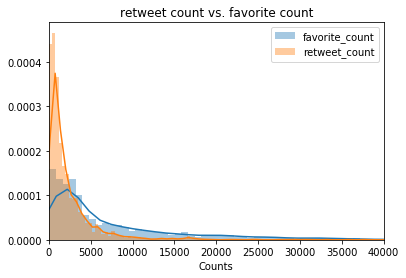

In [84]:
ax = sns.distplot(df_clean['favorite_count'],bins=200)
ax = sns.distplot(df_clean['retweet_count'],bins =200)
ax.set_xlim(0,40000)
plt.xlabel('Counts')
plt.title('retweet count vs. favorite count')
plt.legend(['favorite_count','retweet_count']);

The favorite and retweet counts graph shows that the favorite count is higher than retweet_count in general. One proof is that most of tweets are retweeted less than 5000 times(located with in the interval 0-5000 counts), while tweets gained more likes (more tweets in the interval >5000 counts).

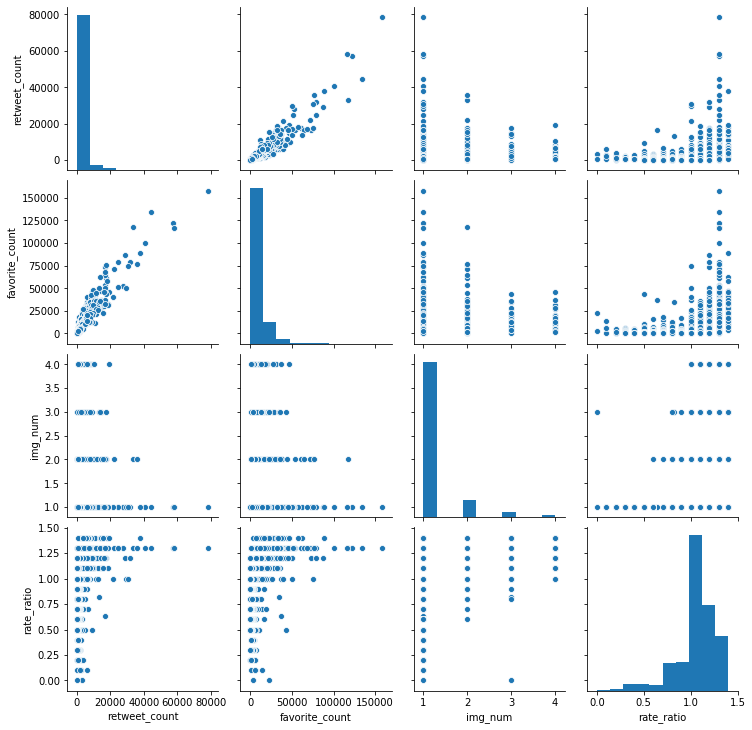

In [85]:
pair = df_clean[['retweet_count','favorite_count','p1','img_num','rate_ratio']]
pair = pair[pair.rate_ratio <= 2]
pair = pair.dropna()
sns.pairplot(pair);

The retweet count and favorite count is highly correlated. The rate ratio might overestimate the images based on the retweet count vs rate ratio and favorite count vs rate ratio. The more images in the tweet, the more likely it has a higher rate while has less chance to be retweeted or like.

#### 4.2.1  Which tweet has the most retweets and/or the most likes?

In [86]:
def top_10(df,column):
    top_10 = df.sort_values(by=[column],ascending=False)[[column,
                                           'Full_text','p1']].head(10)
    return top_10

In [87]:
def plot(ax,xlabel,ylabel,title,labels,leg_labels = None):
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    ax.set_xticklabels(labels,rotation=70);
    if leg_labels:
        plt.legend(leg_labels);

In [88]:
top_10(df_clean,'retweet_count')

,retweet_count,Full_text,p1
769,78486,Here's a doggo realizing you can stand in a pool. enlightened af (vid by Tina Conrad),Labrador_retriever
804,58202,Here's a doggo blowing bubbles. It's downright legendary. would watch on repeat forever (vid by Kent Duryee),Eskimo_dog
396,57246,This is Stephan. He just wants to help. such a good boy,Chihuahua
305,44250,Here's a super supportive puppo participating in the Toronto #WomensMarch today.,Lakeland_terrier
58,40903,This is Duddles. He did an attempt. someone help him (vid by Georgia Felici),English_springer
329,37744,This is Bo. He was a very good First Doggo. would be an absolute honor to pet,standard_poodle
398,35797,"""Good afternoon class today we're going to learn what makes a good boy so good""",Arabian_camel
107,33221,"This is Jamesy. He gives a kiss to every other pupper he sees on his walk. such passion, much tender",French_bulldog
1417,31633,This made my day. please enjoy,swing
1475,30582,This is Kenneth. He's stuck in a bubble. hang in there Kenneth,bubble


In [89]:
top_10(df_clean,'favorite_count')

,favorite_count,Full_text,p1
769,157726,Here's a doggo realizing you can stand in a pool. enlightened af (vid by Tina Conrad),Labrador_retriever
305,134376,Here's a super supportive puppo participating in the Toronto #WomensMarch today.,Lakeland_terrier
396,121747,This is Stephan. He just wants to help. such a good boy,Chihuahua
107,117330,"This is Jamesy. He gives a kiss to every other pupper he sees on his walk. such passion, much tender",French_bulldog
804,116437,Here's a doggo blowing bubbles. It's downright legendary. would watch on repeat forever (vid by Kent Duryee),Eskimo_dog
58,100055,This is Duddles. He did an attempt. someone help him (vid by Georgia Felici),English_springer
329,88869,This is Bo. He was a very good First Doggo. would be an absolute honor to pet,standard_poodle
134,87243,We only rate dogs. This is quite clearly a smol broken polar bear. We'd appreciate if you only send dogs. Thank you...,Angora
92,79103,This is Zoey. She really likes the planet. Would hate to see willful ignorance and the denial of fairly elemental science destroy it.,golden_retriever
1417,79020,This made my day. please enjoy,swing


In [90]:
fr_ratio = top_10(df_clean,'favorite_count').favorite_count/top_10(df_clean,'retweet_count').retweet_count
fr_ratio

58      2.446153
92     NaN      
107     3.531802
134    NaN      
305     3.036746
329     2.354520
396     2.126734
398    NaN      
769     2.009607
804     2.000567
1417    2.498024
1475   NaN      
dtype: float64

In [91]:
# favorite to retweet count ratio.
fr_ratio.mean()

2.5005190892659654

A Labrador retriever has gained the most retweets (78486) and favorite counts (157726). Eight tweets are in both ranking. In general, the favorite count is the 2.5 times the same as retweet count for these eight tweets. A more dedicate study on the relationship between favorite count and retweet counts is conducted in the following sections.

#### 4.2.2 Which breed of dogs have the most tweets based on the predictions?

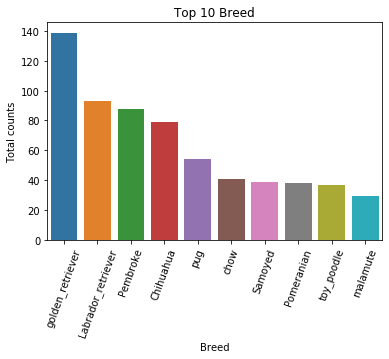

In [92]:
top10_breed = df_clean.p1.value_counts().head(10)
ax = sns.barplot(x = top10_breed.index, y = top10_breed.values)
plot(ax,'Breed','Total counts','Top 10 Breed',top10_breed.index)

Top 10 breeds are golden retriever, labrador, pembroke, Chihuahua, pug, chow, Samoyed, Pomeranian, toy poodle and malamute.

#### 4.2.3 What is the trend of average content length, retweet_count and favorite_count?

In [94]:
# barplot and lineplot
def time_plot(pltype,series,stats,axes=None):
    series_mean = df_clean.groupby(series)[stats].mean()
    if pltype == 'bar':
        ax = sns.barplot(x = series_mean.index, y = series_mean.values,ax=axes)
        plot(ax,series,'AVG ' + stats,'AVG '+ stats + ' by ' + series,series_mean.index)
    if pltype == 'line':
        ax = sns.lineplot(x = series_mean.index, y = series_mean.values,ax =axes)
        plot(ax,'Date','AVG ' + stats,'AVG '+ stats + ' by ' + series,series_mean.index[1:-1:50])
        rolling_mean = series_mean.rolling(window=30).mean()
        plt.plot(rolling_mean, color='orange');

In [95]:
def plot_compare(series,win):
    fig, ax1 = plt.subplots()
    for stats in ['retweet_count','favorite_count']:
        series_mean = df_clean.groupby(series)[stats].mean()
        rolling_mean = series_mean.rolling(window=win).mean()
        plt.plot(rolling_mean);
    plt.xticks(rotation=70)
    plt.legend(labels = ['retweet_count','favorite_count'],loc='upper left')
        
    ax2 = ax1.twinx()
    
    color = 'tab:red'
    stats = 'text_len'
    series_mean = df_clean.groupby(series)[stats].mean()
    rolling_mean = series_mean.rolling(window=win).mean()
    ax2.set_ylabel('text_len', color=color)
    ax2.plot(rolling_mean,color=color)
    ax2.tick_params(axis='y', labelcolor=color)
    plt.legend(labels = ['text_len'],loc='upper right')

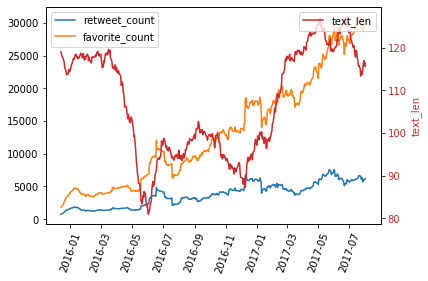

In [96]:
# General trend of retweet count, favorite count and text length. Moving average of 30 days
stats = 'Date'
plot_compare(stats,30)

If we look at the general trend in the entire time period, both retweet count and favorite count follows the same pattern that increases steadily from 2015/12/15 to 2017/8/1, while the favorite count follows a higher growth rate. When it comes to text length, the trend is more complex. It seems people tending to write longer messages during winter and spring and less in the summer and autumn.

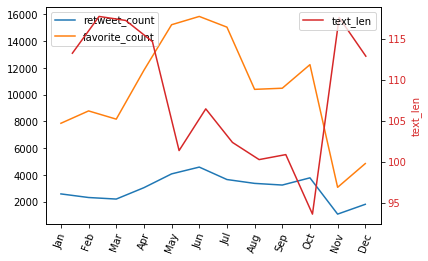

In [97]:
stats = 'Month'
plot_compare(stats,1)
plt.xticks(np.arange(13),calendar.month_abbr[0:13]);

The figure above shows the general trends for different months. For text length, the trend is consistent with the trend in the previous figure that people write more in the cold months and less in the warm months

Interestingly, opposite to the trend of text length, people tend to retweet and like more in the summer and less in the winter.

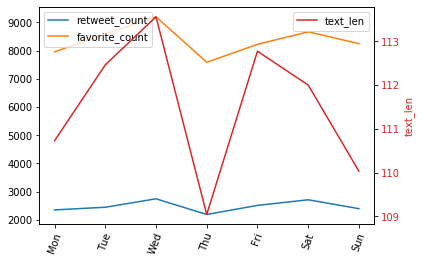

In [98]:
stats = 'DayofWeek'
plot_compare(stats,1)
plt.xticks(np.arange(7),calendar.day_abbr[0:7]);

When it comes to different days in a week, three metrics follow a quite similar pattern that peaks on Wednesdays and Fridays, valleys on Thursdays.

#### 4.2.4 Any relationship between columns?

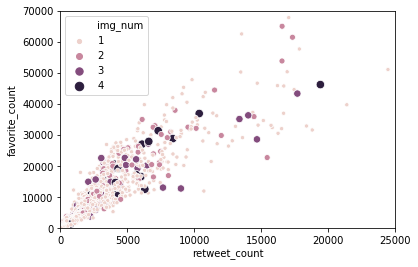

In [99]:
ax = sns.scatterplot(x="retweet_count", y="favorite_count",
                     hue="img_num", size="img_num",
                     data=df_clean)
ax.set_xlim(0,25000)
ax.set_ylim(0,70000);

The scatter plot shows that favorite count and retweet counts has a positive relationship, however, these two variables are heteroscedastic. Heteroscedasticity leads to biased standard errors, therefore it reduce the precision of the coefficient estimates. Here we logarithmize data to correct the draw data.

Unsupervised learning - linear regression

In [100]:
unbias_df = np.log(df_clean[['retweet_count','favorite_count']])

In [101]:
np.sum(unbias_df.isnull())

retweet_count     0
favorite_count    0
dtype: int64

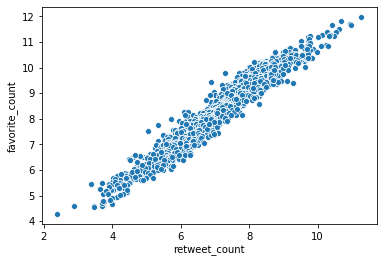

In [102]:
# corrected data
ax = sns.scatterplot(x="retweet_count", y="favorite_count",
                     data=unbias_df)

In [103]:
#  linear approach to modeling the relationship betweet two counts
X = np.array(unbias_df.retweet_count).reshape(-1,1)
y = np.array(unbias_df.favorite_count).reshape(-1,1)
reg = LinearRegression().fit(X, y)
reg.score(X, y), reg.coef_, reg.intercept_

(0.9365302050449351, array([[1.01202801]]), array([1.1146794]))

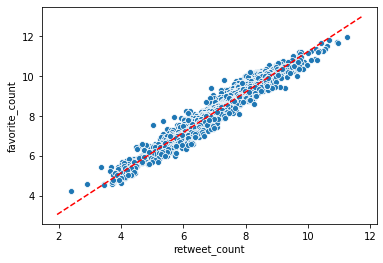

In [104]:
# use the underlying relationship
ax = sns.scatterplot(x="retweet_count", y="favorite_count",
                     data=unbias_df)
def abline(slope, intercept):
    """Plot a line from slope and intercept"""
    axes = plt.gca()
    x_vals = np.array(axes.get_xlim())
    y_vals = intercept + slope * x_vals
    plt.plot(x_vals, y_vals, '--',color='red')
abline(reg.coef_[0][0],reg.intercept_[0])


It is obvious that retweet count and favorite count are positively related. We can use the red line to predict one of the counts if the other is given.

 <a id='5'></a>
 ## 5 Conclusion and Limitations

According to the analysis, among all breeds golden retriever has the most retweets and favorite. However, the top 1 favorite and retweeted tweet is about a Labrador retriever doggo. 

The pattern and trend study shows that people prefer to like a tweet more than retweet it. When it is cold outside, people tend to retweet and/or like more tweets and the total length of tweets tends to be short. In contrast, in the summer people prone to write more and retweet less.

The retweet count and the favorite count is highly related. A regression line can be used to predict the retweet count based on the favorite count, vice versa.

Even though heteroscedasticity is largely corrected by the logrithmization process, the scatter plot shows that the standard deviation is not constant. This phenomenon leads to a slightly biased confidence interval of the computed coefficient and interception.